# Predictive Analysis

A few thoughts based on the following analysis:
- If MLS Real Estate data could be made available for training the model, the number of available features would increase and provide data that is external from the current assessment calculation.
    - Features like number of rooms and housing size (area) could drastically improve the model
    - We can see a similar trend, of strong predredictive features, when analysing similar datasets, such as the [Boston Housing](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) dataset.
- Training the data on a previous year's data should be tested on the current year's data to see the relevance of predicting annual data from the model.
- As a researcher it is also important to understand that assessment values are utilized to calculate property owner's annual taxes. These taxes are then used to offset the municipality's annual budget and community expansion. Therefore, if the municipality passes a significantly higher budget or there is significant community expansion in a particular area, these factors will affect the assessment values in ways that we cannot predict with our current data.

# Dummy Variables

Utilizing dummy variables for `zoning`, `garage`, and `neighbourhood` resulted in very high dimensionality and decreased scoring results.

### Alternative approach

The `garage` feature was simply converted to an integer, the `zoning` feature was converted to an integer utilizing a dictionary and the `map()` method, and the `neighbourhood` was left in its integer ID form.

This approach results in marginally better scoring for all learners.

# After Feature Engineering

After the feature set is complete, the Random Forest Regressor performs marginally better than the ExtraTreesRegressor and significantly better than a simple Linear Regressor. Resulting in a mean error of \$96,985.34

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [2]:
ml = pd.read_csv('property_assess_1.csv', index_col=0)

In [3]:
ml.garage = ml.garage.astype(int)

In [4]:
zones_map = {'RF1':1, 'RF4':2, 'RSL':3, 'RF5':4, 'RA7':5, 'RPL':6, 'RF6':7, 'RMD':8, 'RF3':9,\
       'RA8':10, 'RR':11, 'RA9':12, 'UCRH':13, 'RF2':14, 'RA8h':15, 'RMH':16, 'RA7a':17, 'TSLR':18,\
       'RF4t':19, 'RPLt':20, 'RF5t':21, 'RA7*':22, 'TSDR':23, 'RA9*':24, 'RF6*':25, 'HDR':26,\
       'RMU':27, 'CR':28, 'RF5g':29, 'RA7g':30, 'EETR':31}

ml.zoning = ml.zoning.map(zones_map)
ml.head()

,value,nb_id,garage,zoning,lot_size,year_built,crime_per_capita
0,381500,2521.0,1,6,288.0,2013.0,0.015382
1,569500,2521.0,1,3,373.0,2015.0,0.015382
2,556000,2521.0,1,3,390.0,2015.0,0.015382
3,373000,2521.0,1,2,346.0,2014.0,0.015382
4,168000,2521.0,0,3,360.0,NaN,0.015382


In [5]:
X = ml.drop('value', axis=1).values
y = ml['value'].values

In [6]:
y.reshape(-1,1)

array([[ 381500],
       [ 569500],
       [ 556000],
       ...,
       [1733500],
       [ 449500],
       [ 358500]])

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [8]:
# Setup the pipeline steps: steps
steps = [('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('rfr', ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None, max_leaf_nodes=None, 
                                     max_features='auto', min_impurity_decrease=0.0, min_impurity_split=None, 
                                     min_samples_leaf=1, min_samples_split=2, 
                                     min_weight_fraction_leaf=0.0, n_jobs=-1, 
                                     oob_score=False, random_state=123, verbose=False, warm_start=False))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(1, 121)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: yeg_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv.best_params_))
print("Tuned RandomForest Mean Squared Error: {}".format(mse))
print('Mean Error:', np.sqrt(abs(mse)))

Tuned RandomForest estimators: {'rfr__n_estimators': 121}
Tuned RandomForest Mean Squared Error: -7462138793.719412
Mean Error: 86383.67203192634


In [9]:
for i in [1, 10, 100, 1000, 10000, 100000]:
    print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[i])), 'actual value:', np.atleast_2d(y_test[i]))

predicted value: [789994.21487603] actual value: [[562000]]
predicted value: [522605.37190083] actual value: [[671500]]
predicted value: [306142.59120127] actual value: [[306500]]
predicted value: [514095.04132231] actual value: [[522000]]
predicted value: [138000.] actual value: [[138000]]
predicted value: [195651.67721868] actual value: [[200000]]


In [10]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

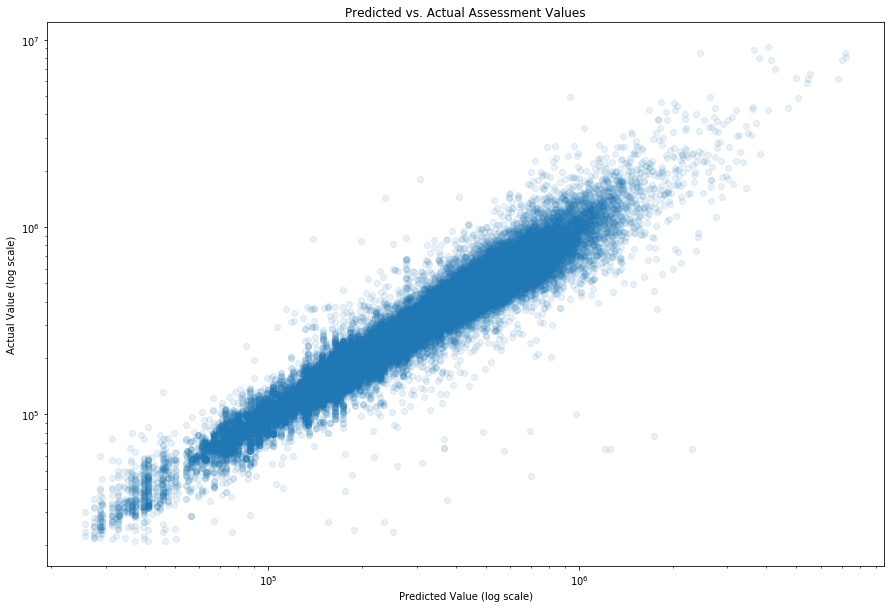

In [11]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.1)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [12]:
joblib.dump(yeg_cv, 'LowFeatXtraTrees.joblib')

['LowFeatXtraTrees.joblib']

# Best Performing Learner:

# Random Forest Regressor

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
# Setup the pipeline steps: steps
steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),
         ('scaler', StandardScaler()),
         ('rfr', RandomForestRegressor(max_depth=20))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(10,100)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: gm_cv
yeg_cv_reg = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)

# Fit to the training set
yeg_cv_reg.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv_reg.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv_reg.best_params_))
print("Tuned RandomForest mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned RandomForest estimators: {'rfr__n_estimators': 100}
Tuned RandomForest mean squared error: -8041307627.982433
89673.33844561846


In [14]:
joblib.dump(yeg_cv_reg, 'RandomForestReg.joblib')

['RandomForestReg.joblib']

In [15]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

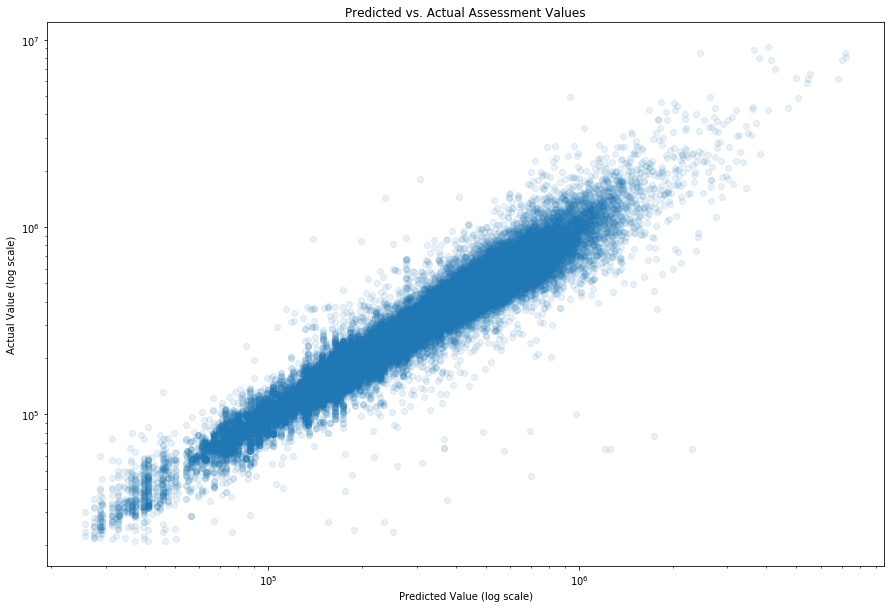

In [16]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.1)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# Setup the pipeline steps: steps
steps = [('imputation', SimpleImputer(missing_values=np.nan)),
         ('scaler', StandardScaler()),
         ('reg', LinearRegression())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'imputation__strategy':('most_frequent','mean')}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: gm_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned Imputer Parameters: {}".format(yeg_cv.best_params_))
print("Tuned Linear Regression mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned Imputer Parameters: {'imputation__strategy': 'mean'}
Tuned Linear Regression mean squared error: -33030493971.590828
181742.93375972236


In [19]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

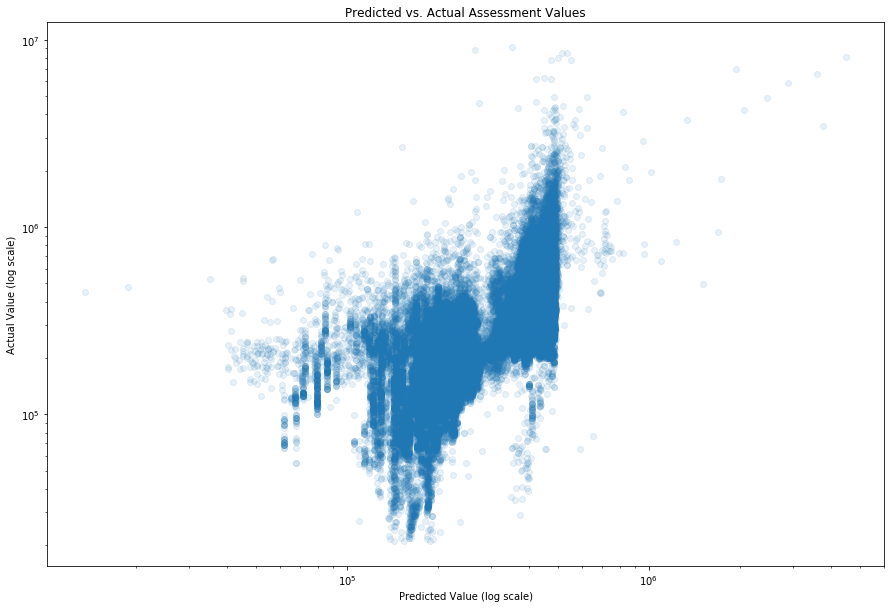

In [20]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.1)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()